# Install the required packages

In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install scikit-learn

# Download the dataset and load datas

In [1]:
import os
import kagglehub

path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")
file_path1 = os.path.join(path, "yellow_tripdata_2015-01.csv")  # Path to the dataset file
file_path2 = os.path.join(path, "yellow_tripdata_2016-01.csv")  # Path to the dataset file
file_path3 = os.path.join(path, "yellow_tripdata_2016-02.csv")  # Path to the dataset file
file_path4 = os.path.join(path, "yellow_tripdata_2016-03.csv")  # Path to the dataset file

In [2]:
# Verifica degli attributi presenti
import pandas as pd
df_sample = pd.read_csv(file_path1, nrows=5)
print(df_sample.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


# Load only the needed columns

In [3]:
import pandas as pd

needed_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tip_amount",            # Importo della mancia
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
    "tpep_pickup_datetime",  # Data e ora di inizio del viaggio
    # "tpep_dropoff_datetime", # Data e ora di fine del viaggio (forse inutile)
    # "pickup_longitude",      # Longitudine del punto di partenza (forse inutile)
    # "pickup_latitude",       # Latitudine del punto di partenza (forse inutile)
    # "dropoff_longitude",     # Longitudine del punto di arrivo (forse inutile)
    # "dropoff_latitude",      # Latitudine del punto di arrivo (forse inutile)
    "payment_type"           # Tipo di pagamento (target)
]

df_2015_01 = pd.read_csv(file_path1, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_01 = pd.read_csv(file_path2, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_02 = pd.read_csv(file_path3, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_03 = pd.read_csv(file_path4, usecols=needed_columns)    # Load the dataset  in a DataFrame

# Join the different dataframes

In [4]:
df = pd.concat([df_2015_01, df_2016_01, df_2016_02, df_2016_03], ignore_index=True)
print (df.columns)

Index(['tpep_pickup_datetime', 'passenger_count', 'trip_distance',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')


# Transformation: managing null values (if exist)

In [5]:
def check_null_values(df):
    if df.isnull().values.any():
        print("Il DataFrame contiene valori nulli.")
        # Mostra le colonne con valori nulli e il conteggio di tali valori
        null_columns = df.isnull().sum()
        print("Colonne con valori nulli:")
        print(null_columns[null_columns > 0])
    else:
        print("Non ci sono valori nulli nel DataFrame.")
        
check_null_values(df)

Il DataFrame contiene valori nulli.
Colonne con valori nulli:
improvement_surcharge    3
dtype: int64


In [6]:
# Dato che i valori nulli sono pochi, possiamo eliminare i record contenenti i valori nulli
num_rows_before = df.shape[0]
print(num_rows_before)
df_cleaned = df.dropna()
num_rows_after = df_cleaned.shape[0]
print(num_rows_after)

47248845
47248842


# Verifying the balance of the dataset

In [7]:
# Conta le occorrenze di ciascun codice di pagamento
payment_type_counts = df_cleaned['payment_type'].value_counts()

# Stampa i risultati
print("Conteggio delle righe per ciascun codice di pagamento:")
print(payment_type_counts)

# No charge payment significa che il passeggero non è stato addebitato per il viaggio.
# Dispute payment indica che il pagamento è stato contestato dal cliente.
# Non essendo rilevanti ai fini dell'analisi, abbiamo deciso di eliminare le righe che presentano payment type pari a 3, 4, 5

# Elimina le righe con valori 3, 4, o 5 nella colonna 'payment_type'
df_filtered = df_cleaned[~df_cleaned['payment_type'].isin([3, 4, 5])]
print("Nuovo numero di righe: ")
print(df_filtered.shape[0])

Conteggio delle righe per ciascun codice di pagamento:
payment_type
1    30870611
2    16158086
3      164138
4       56004
5           3
Name: count, dtype: int64
Nuovo numero di righe: 
47028697


# Transformation: normalizing the values

In [12]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tip_amount",            # Importo della mancia
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
]

def normalize_numeric_columns(df, numeric_columns):
    # Inizializza lo scaler per la normalizzazione
    scaler = MinMaxScaler()
    # Normalizza solo le colonne numeriche
    df.loc[:, numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

# Normalizzazione delle colonne numeriche
df_normalized = normalize_numeric_columns(df_filtered, numeric_columns)
# print(df_normalized)
print(df_normalized.columns)

# Seleziona solo le colonne specificate in numeric_columns
numeric_df_normalized = df_normalized[numeric_columns]
# print (numeric_df_normalized)
print(numeric_df_normalized.columns)

Index(['tpep_pickup_datetime', 'passenger_count', 'trip_distance',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'pickup_period'],
      dtype='object')
Index(['trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'improvement_surcharge', 'tip_amount', 'tolls_amount', 'total_amount',
       'passenger_count'],
      dtype='object')


# Using get_dummies() for tpep_pickup_datetime and payment_type features

In [13]:
# A seconda del momento della giornata in cui inizia la corsa, il prezzo totale può cambiare
def get_period(hour):
    if 6 <= hour < 18:
        return 'giorno'
    else:
        return 'notte'

# Converti le colonne in formato datetime
df_normalized['tpep_pickup_datetime'] = pd.to_datetime(df_normalized['tpep_pickup_datetime'])
# Crea una nuova colonna "pickup_period" per indicare giorno o notte
df_normalized['pickup_period'] = df_normalized['tpep_pickup_datetime'].dt.hour.apply(get_period)
print(df_normalized)

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_5991/1009854752.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['tpep_pickup_datetime'] = pd.to_datetime(df_normalized['tpep_pickup_datetime'])


         tpep_pickup_datetime  passenger_count  trip_distance  payment_type  \
0         2015-01-15 19:05:39         0.111111       0.150939             1   
1         2015-01-10 20:33:38         0.111111       0.150940             1   
2         2015-01-10 20:33:38         0.111111       0.150939             2   
3         2015-01-10 20:33:39         0.111111       0.150939             2   
4         2015-01-10 20:33:39         0.111111       0.150940             2   
...                       ...              ...            ...           ...   
47248840  2016-03-31 16:34:36         0.111111       0.150939             2   
47248841  2016-03-26 03:02:32         0.111111       0.150939             1   
47248842  2016-03-20 08:43:59         0.111111       0.150940             1   
47248843  2016-03-20 08:49:47         0.111111       0.150940             1   
47248844  2016-03-20 08:50:24         0.111111       0.150940             1   

          fare_amount     extra   mta_tax  tip_amou

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_5991/1009854752.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['pickup_period'] = df_normalized['tpep_pickup_datetime'].dt.hour.apply(get_period)


In [14]:
# Usa get_dummies per trasformare la colonna pickup_period in one-hot encode
# 1 è notte, 0 è giorno

# Applica get_dummies per trasformare la colonna pickup_period in variabili dummy
df_normalized = pd.get_dummies(df_normalized, columns=['pickup_period'], drop_first=True)

# Converte pickup_period_notte da booleano a intero (1 per True (carta di credito), 0 per False)
df_normalized['pickup_period_notte'] = df_normalized['pickup_period_notte'].astype(int)
# Crea una colonna binaria 'payment_type_creditCard' che è 1 se 'payment_type' è 1, altrimenti 0
df_normalized['payment_type_creditCard'] = (df_normalized['payment_type'] == 1).astype(int)

print(df_normalized)


         tpep_pickup_datetime  passenger_count  trip_distance  payment_type  \
0         2015-01-15 19:05:39         0.111111       0.150939             1   
1         2015-01-10 20:33:38         0.111111       0.150940             1   
2         2015-01-10 20:33:38         0.111111       0.150939             2   
3         2015-01-10 20:33:39         0.111111       0.150939             2   
4         2015-01-10 20:33:39         0.111111       0.150940             2   
...                       ...              ...            ...           ...   
47248840  2016-03-31 16:34:36         0.111111       0.150939             2   
47248841  2016-03-26 03:02:32         0.111111       0.150939             1   
47248842  2016-03-20 08:43:59         0.111111       0.150940             1   
47248843  2016-03-20 08:49:47         0.111111       0.150940             1   
47248844  2016-03-20 08:50:24         0.111111       0.150940             1   

          fare_amount     extra   mta_tax  tip_amou

# Feature Correlation

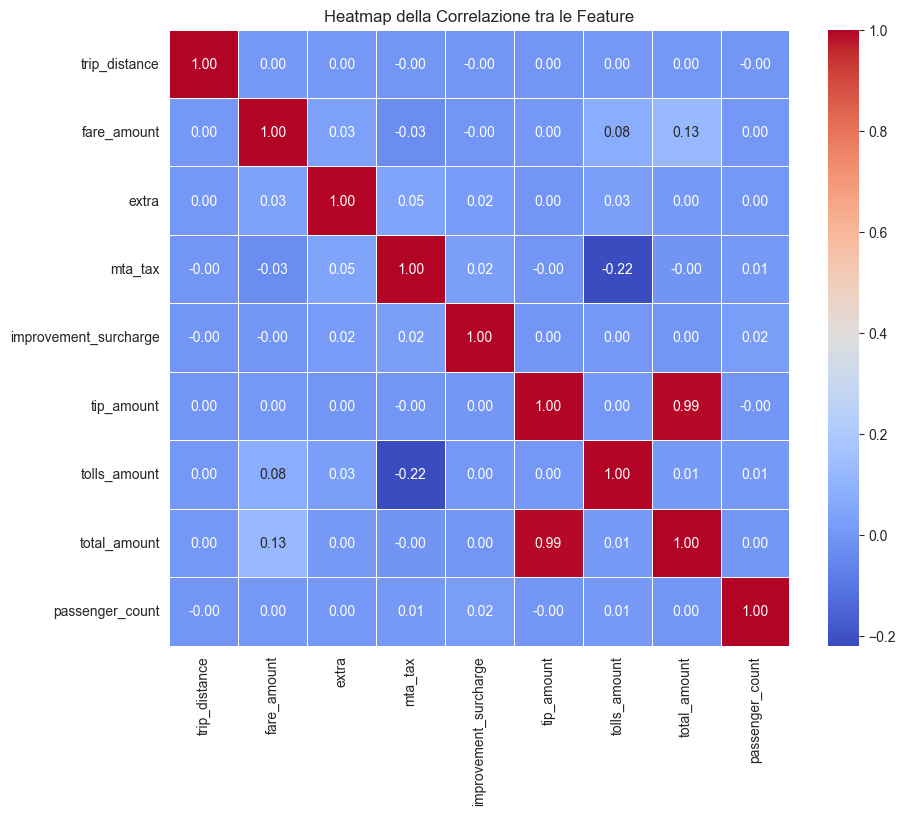

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione (tiene in considerazione solo gli attributi numerici)
correlation_matrix = numeric_df_normalized.corr()

# Imposta la dimensione della figura
plt.figure(figsize=(10, 8))

# Crea la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Aggiungi titolo e mostra la heatmap
plt.title("Heatmap della Correlazione tra le Feature")
plt.show()

# Deleting the features highly correlated

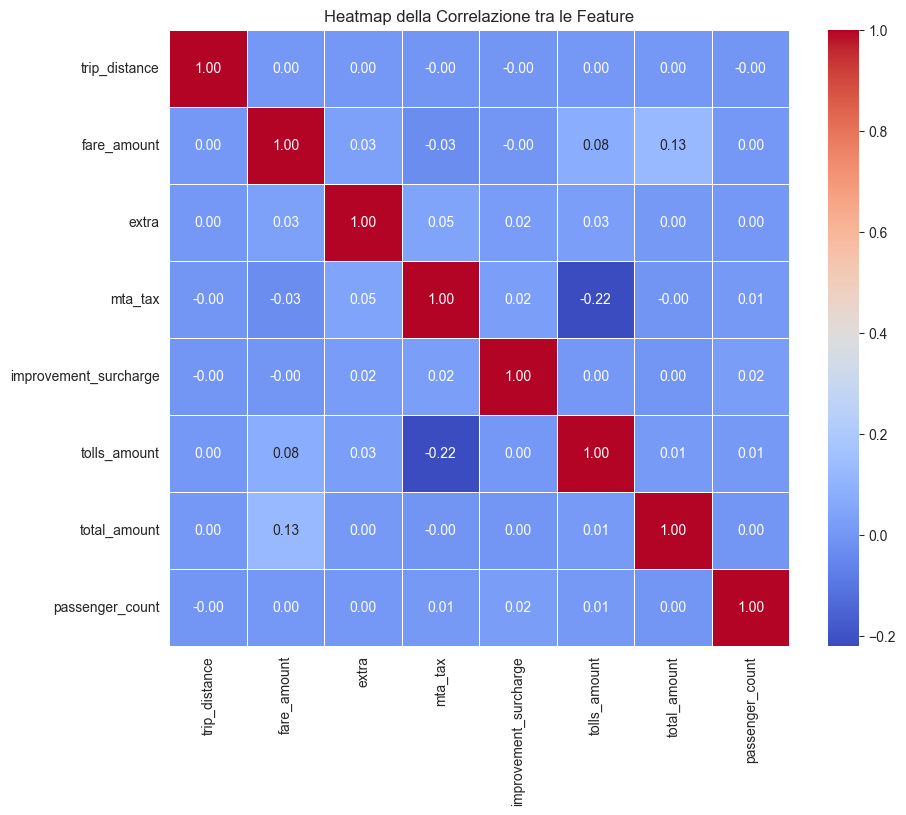

In [16]:
# Eliminazione di tip_amount dalla colonne da tenere in considerazione
# In quanto la feature genera due alti livelli di correlazione

new_numeric_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
]

new_numeric_df_normalized = numeric_df_normalized[new_numeric_columns]

# Calcola la matrice di correlazione
correlation_matrix = new_numeric_df_normalized.corr()

# Imposta la dimensione della figura
plt.figure(figsize=(10, 8))

# Crea la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Aggiungi titolo e mostra la heatmap
plt.title("Heatmap della Correlazione tra le Feature")
plt.show()

In [17]:
final_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
    "payment_type_creditCard", # Tipo di pagamento
    "pickup_period_notte", # Inizio della corsa
]

# Mantieni solo le colonne specificate in final_columns
df_normalized = df_normalized[final_columns]
print (df_normalized)

          trip_distance  fare_amount     extra   mta_tax  \
0              0.150939     0.001075  0.074143  0.016538   
1              0.150940     0.001080  0.073680  0.016538   
2              0.150939     0.001069  0.073680  0.016538   
3              0.150939     0.001055  0.073680  0.016538   
4              0.150940     0.001082  0.073680  0.016538   
...                 ...          ...       ...       ...   
47248840       0.150939     0.001091  0.074143  0.016538   
47248841       0.150939     0.001056  0.074143  0.016538   
47248842       0.150940     0.001168  0.073217  0.016538   
47248843       0.150940     0.001145  0.074143  0.016538   
47248844       0.150940     0.001168  0.073217  0.016538   

          improvement_surcharge  tolls_amount  total_amount  passenger_count  \
0                           1.0      0.008546      0.000118         0.111111   
1                           1.0      0.008546      0.000118         0.111111   
2                           1.0      0.

# Divisione tra training set e test set (K-fold cross validation)

In [ ]:
## Non usare questo script

from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier  # Usa il modello che preferisci

X = df_normalized.drop(columns='payment_type_creditCard')  # Feature di input (esclusa la colonna target)
y = df_normalized['payment_type_creditCard']               # Target

# Definisci il numero di fold per la K-Fold Cross Validation
# Il modello esegue n_splits iterazioni
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Scegli il modello (es. RandomForestClassifier)
model = RandomForestClassifier()

# Applica la K-Fold Cross Validation
scores = cross_val_score(model, X, y, cv=kf)

# Stampa i punteggi di ciascun fold e la media
print("Punteggi per ciascun fold:", scores)
print("Punteggio medio:", scores.mean())

In [18]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Funzione di salvataggio checkpoint
# Vengono salvati con il seguente nome: "random_forest_fold_{fold}.pkl"
# Per riprendere un checkpoint, utilizzare joblib.load(filename)
def save_checkpoint(model, fold):
    filename = f"{checkpoint_dir}/random_forest_fold_{fold}.pkl"
    joblib.dump(model, filename)
    print(f"Checkpoint salvato: {filename}")

X = df_normalized.drop(columns='payment_type_creditCard')  # Feature di input
y = df_normalized['payment_type_creditCard']               # Target

# Definisci il numero di fold per la K-Fold Cross Validation
# Il modello esegue n_splits iterazioni
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Modello con parametri personalizzati
model = RandomForestClassifier()

# Cartella per salvare i checkpoint
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Iterazione manuale per ciascun fold
fold_scores = []
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print(f"Fold {fold}/{kf.get_n_splits()}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Addestramento del modello sul fold corrente
    model.fit(X_train, y_train)
    
    # Valutazione sul fold corrente
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_scores.append(accuracy)
    print(f"Accuratezza del fold {fold}: {accuracy}")

    # Salva un checkpoint del modello addestrato per questo fold
    save_checkpoint(model, fold)

# Calcola e stampa la media dei punteggi di tutti i fold
print("Punteggi per ciascun fold:", fold_scores)
print("Punteggio medio:", sum(fold_scores) / len(fold_scores))


Fold 1/10
Accuratezza del fold 1: 0.6694722584294271
Checkpoint salvato: checkpoints/random_forest_fold_1.pkl
Fold 2/10


KeyboardInterrupt: 